<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#План-работы" data-toc-modified-id="План-работы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>План работы</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-градиентного-бустинга-lightGBM" data-toc-modified-id="Модель-градиентного-бустинга-lightGBM-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Модель градиентного бустинга lightGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## План работы 

Для успешного выполнения проекта необходимо выполнить следующие действия:
- ресемплировать данные по одному часу
- исследовать данные:
  - исследовать сезонность и тренды полученных данных
  - определить подходящий лаг для обучения модели
- обучить несколько различных моделей с различными гиперпараметрами и выбрать оптимальную модель
- проверить выбранную модель на тестовой выборке

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import lightgbm as lgb

from sklearn.metrics import mean_squared_error

## Подготовка

Загрузим исходный датасет.

In [2]:
local_path = 'taxi.csv'
server_path = '/datasets/taxi.csv'

if os.path.exists(local_path):
    data = pd.read_csv(local_path, index_col=[0], parse_dates=[0])
else:
    data = pd.read_csv(server_path, index_col=[0], parse_dates=[0])

In [3]:
print(data.info)
data.head(10)

<bound method DataFrame.info of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
print(data.index.is_monotonic_increasing)

True


Датасет представляет собой упорядоченные по времени данные.

Исходный датасет представляет собой данные за каждые 10 минут.Ресемплируем датасет, суммой за каждый час.

In [5]:
data = data.resample('1H').sum()

In [6]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

Проанализируем данные из датасета, чтобы определить сезонность.

Как мы видим, пиковые значения повторяются каждые сутки, что позволяет нам говорить о сезонности значений в пределах суток.

Рассмотрим сезонность и тренд имеющихся данных

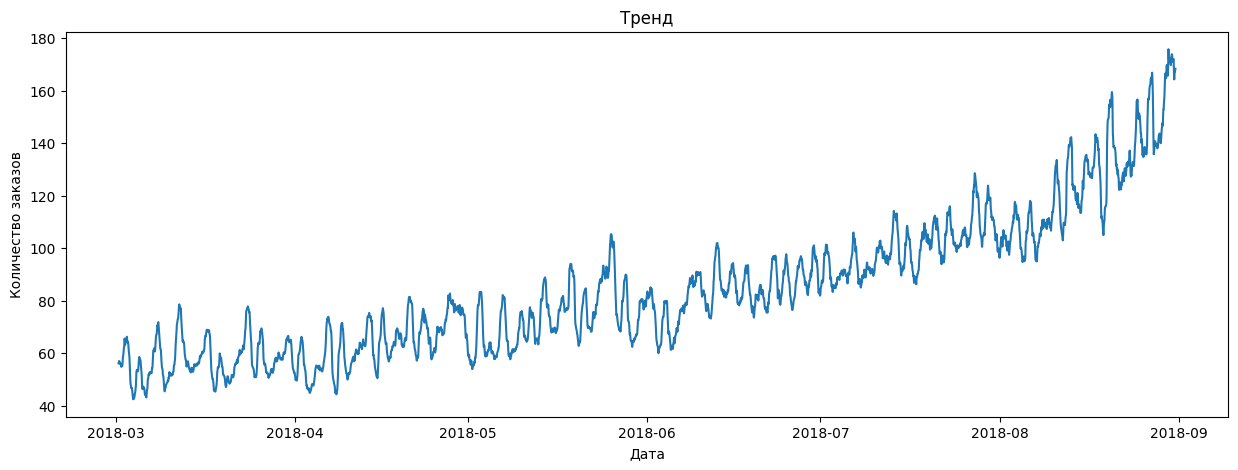

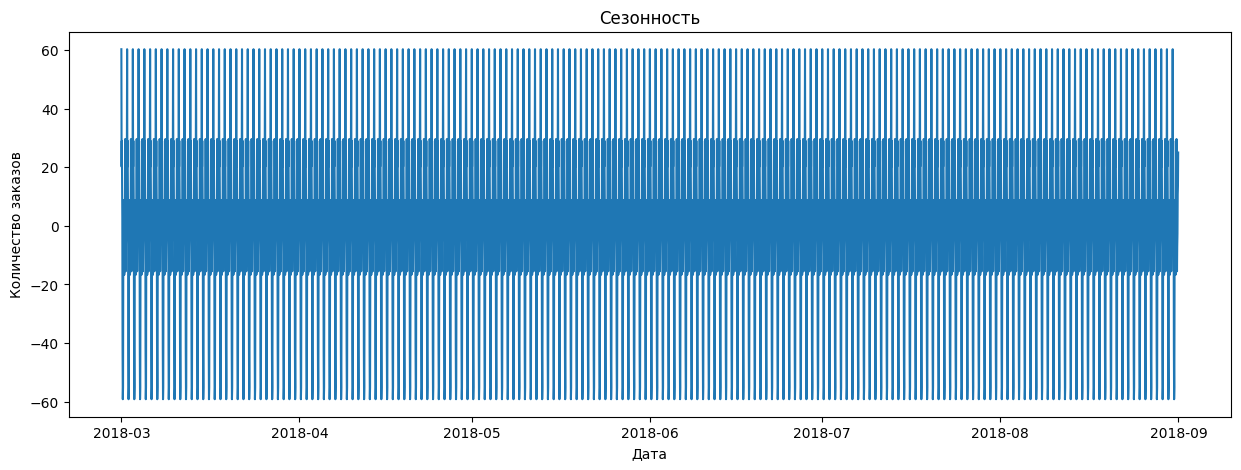

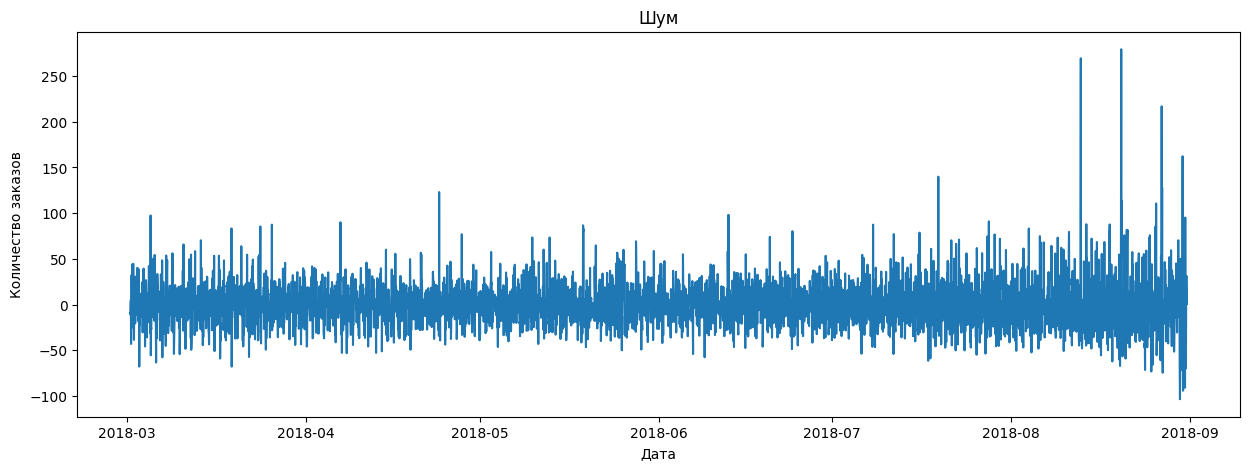

In [7]:
WIDTH_SIZE = 15
HEIGHT_SIZE = 5

def make_plot(title, data):
    plt.figure(
        figsize=(WIDTH_SIZE,HEIGHT_SIZE)
    )
    plt.plot(data)
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.show()
    
def decomposed_plots(data):
    make_plot('Тренд', data.trend)
    make_plot('Сезонность', data.seasonal)
    make_plot('Шум', data.resid)
    
decomposed = seasonal_decompose(data)

decomposed_plots(decomposed)

По данным графикам видно, что присутствует очень частая сезонность - скорее всего в пределах суток. Кроме того, можно отметить растущий тренд, особенно ускоряющийся к августу (возможно к периоду отпусков).

Рассмотрим график сезонности за несколько дней.

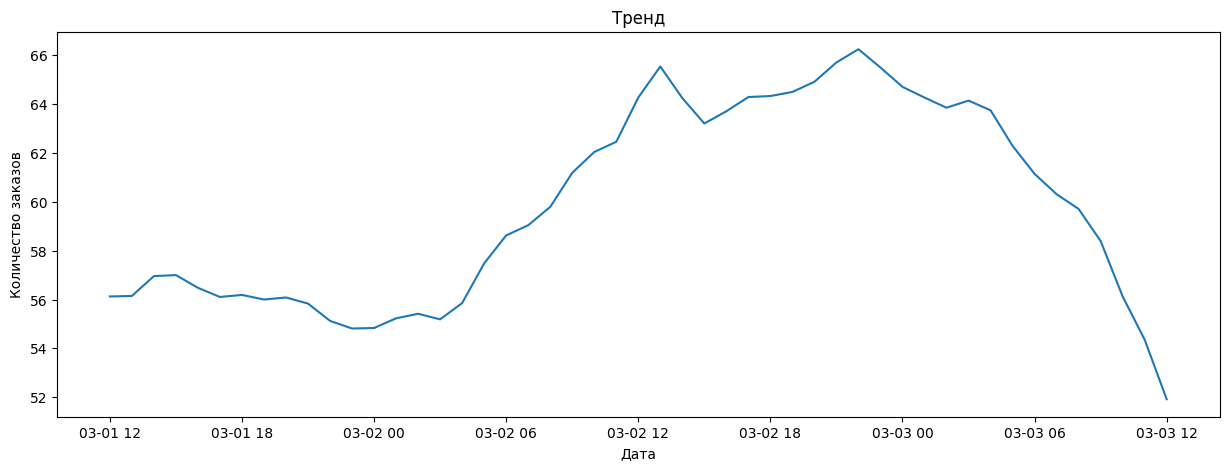

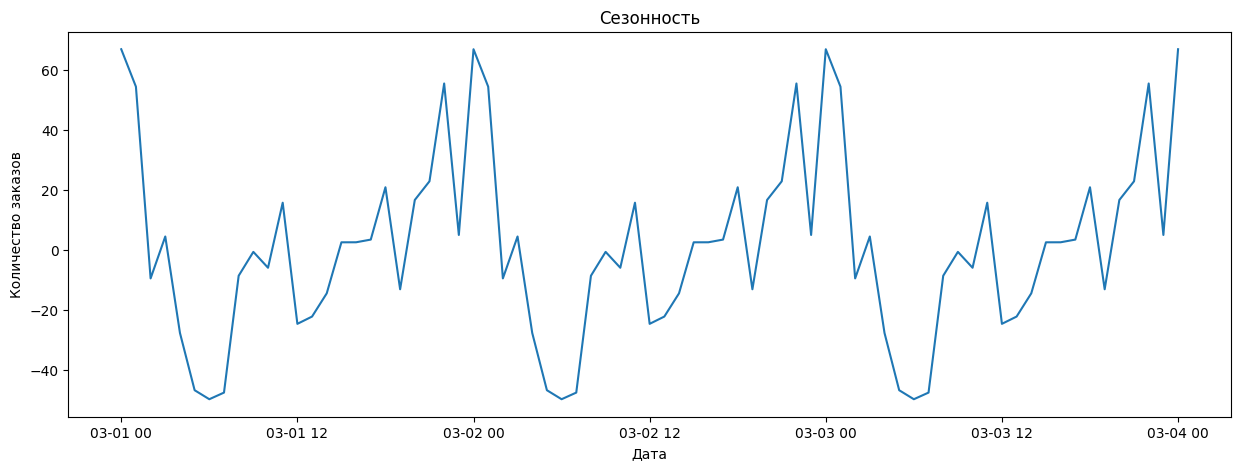

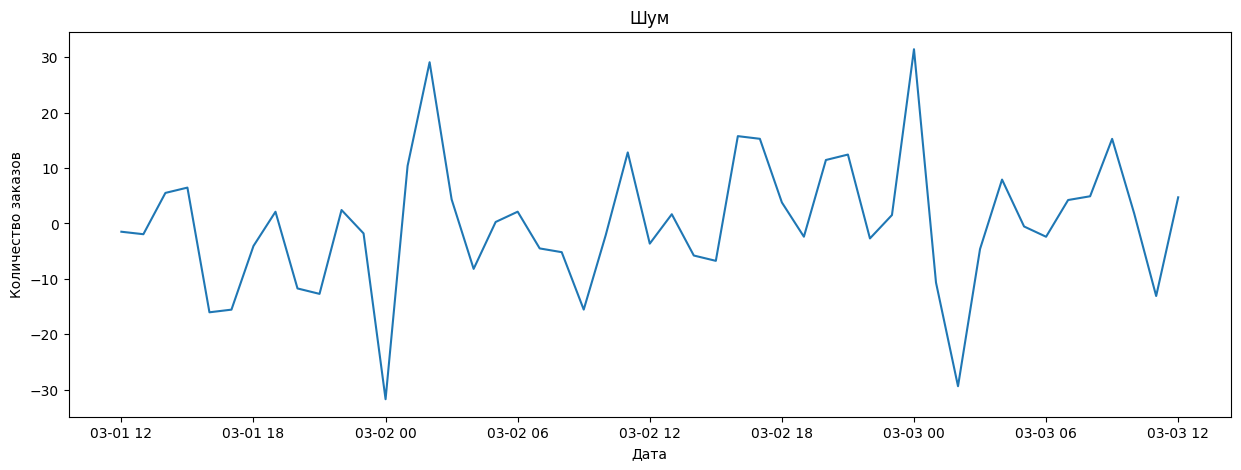

In [8]:
data_week = data['2018-03-01 00:00:00':'2018-03-04 00:00:00']
decomposed_week = seasonal_decompose(data_week)

decomposed_plots(decomposed_week)

Наблюдается четкий повтор пиков в пределах суток, как и было предположено при анализе общего графика.

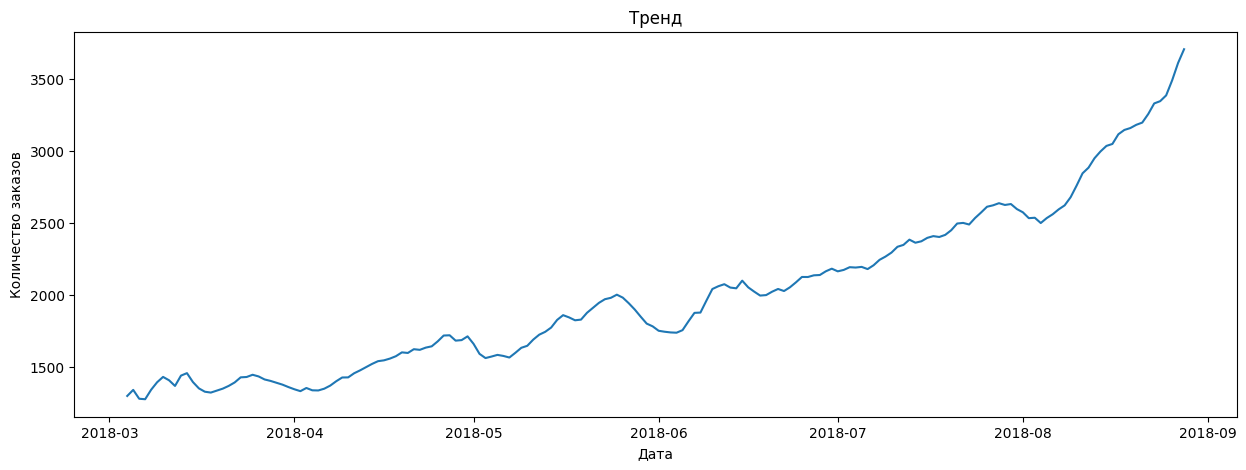

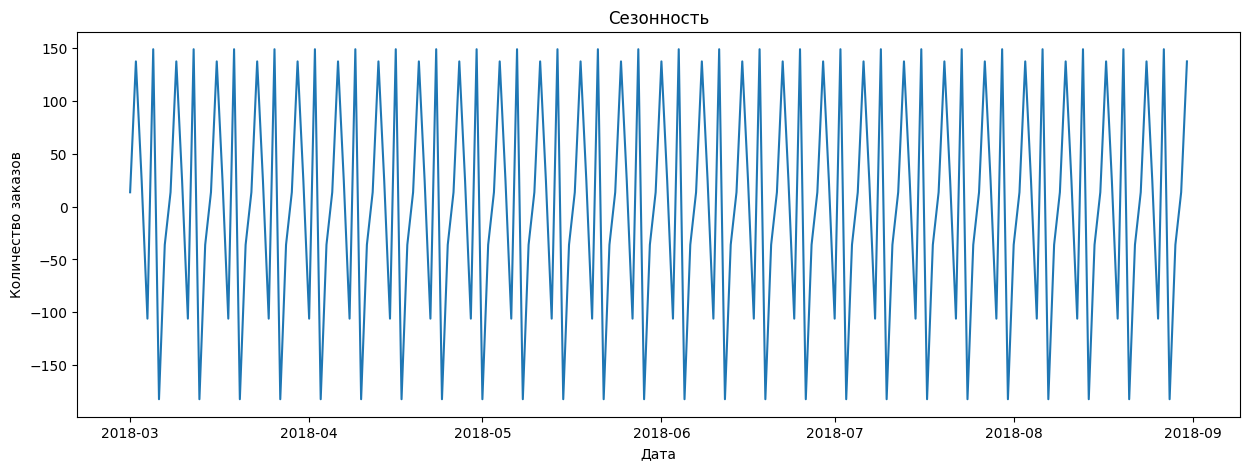

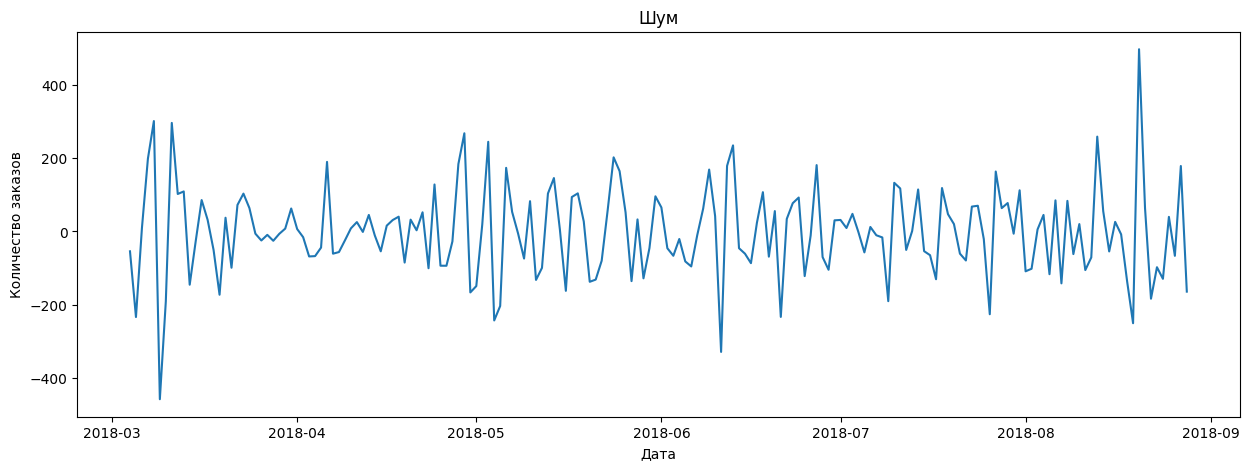

In [9]:
data_day = data.resample('1D').sum()

decomposed_day = seasonal_decompose(data_day)

decomposed_plots(decomposed_day)

Во-первых можно отметить, что тренд восходящий - количество заказов растет. Во-вторых, в пределах одного месяца повторяются пики и снижения. За месяц таких повторов около 4-5, что соответствует количеству недель в месяце, то есть присутствует недельная сезонность.

Построим график автокорреляции.

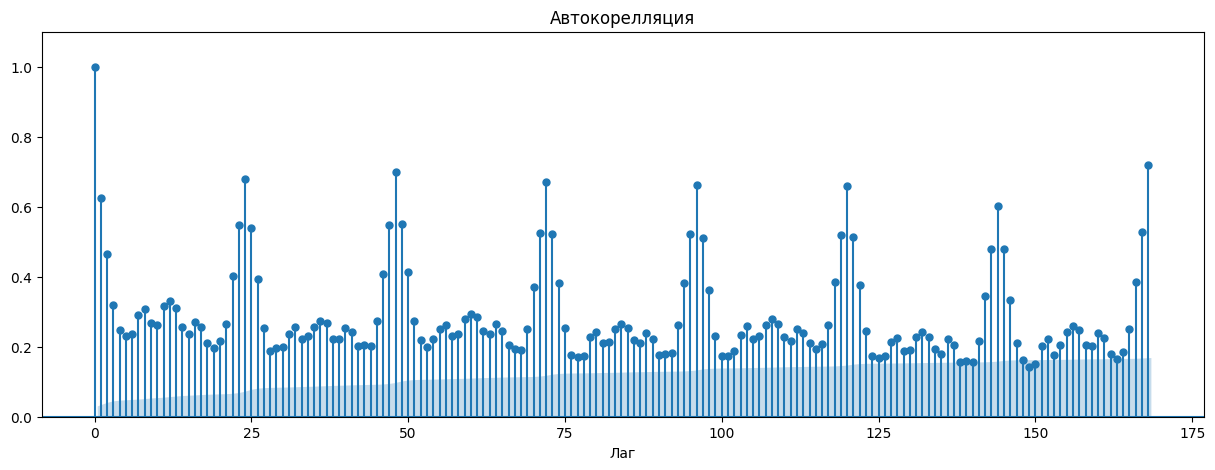

In [10]:
fig = tsaplots.plot_acf(data,lags=24*7)
plt.ylim(0.0, 1.1)
plt.title('Автокорелляция')
plt.xlabel('Лаг')
fig.set_size_inches(WIDTH_SIZE, HEIGHT_SIZE)
plt.show()

### Вывод

По итогам анализа было выявлено, что присутствует суточная и недельная сезонность, а так же наличие восходящего тренда. По итогам анализа будут добавлены новые признаки - признаки дня недели, признаки часа, а так же первые 12 лагов.

## Обучение

### Подготовка данных

Как было видно из анализа данных, у нас имеется сезонность внутри дня, то есть каждый день количество заказов растет к определенному часу, и сезонность внутри недели.

Добавим в качестве признака день недели.

In [11]:
data['dayofweek'] = data.index.dayofweek

Кроме того, сформируем отстающие признаки, с лагом 24, соответствующим 1 суткам, и с лагом в 168, соответствующим одной неделе. Помимо этого, значение каждого часа будет зависеть и от предыдущего значения, то есть сезонность и тренд в первую очередь будут влиять на направление изменения значения, но не на сам его модуль.

In [12]:
for lag in range(1,12,1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
for lag in (24,168):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

В ходе анализа был выявлен общий растущий тренд количества заказов. Поэтому, добавим скользящее среднее за последние сутки.

In [13]:
data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()

Разобьем данные на тренировочную и тестовую выборки в отношении 9:1.

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [15]:
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Для модели линейной регрессии смасштабируем признаки.

### Обучение моделей 

Добавим константное значение для случайного состояния для дальнейшего удобства.

In [16]:
RANDOM_STATE = 12345

Так же, сразу пропишем метод кросс-валидации, поскольку временные ряды требуют отличного метода от стандартного.

In [17]:
tscv = TimeSeriesSplit(n_splits=5)

#### Модель линейной регрессии 

Для начала проверим модель линейной регрессии.

In [18]:
linear_model = LinearRegression()

lin_reg_params = {
}

In [19]:
best_lin_reg_model = RandomizedSearchCV(
    linear_model,
    lin_reg_params,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter=1,
    cv=tscv
)

best_lin_reg_model.fit(train_features, train_target)
best_lin_reg_model.best_score_ * -1

23.062424499640244

По итогам кроссвалидации модель линейной регрессии показала результат RMSE, равный 23.06.

#### Модель случайного леса 

In [20]:
random_forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

forest_model_params = {
    'n_estimators' : range(10,50,10),
    'max_depth' : [None] + [i for i in range(2, 7)],
    'min_samples_split' : range(2, 11, 5),
    'min_samples_leaf' : range(1,11,5),
    'max_features' : [1, 'sqrt', 'log2']
}

In [21]:
best_forest_model = RandomizedSearchCV(
    random_forest_model,
    forest_model_params,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    cv=tscv
)

best_forest_model.fit(train_features, train_target)
best_forest_model.best_score_ * -1

Fitting 5 folds for each of 50 candidates, totalling 250 fits


23.401124655520007

По итогам кроссвалидации модель случайного показала результат RMSE, равный 23.4, что хуже линейной регрессии.

#### Модель градиентного бустинга lightGBM

In [22]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    random_state=RANDOM_STATE
)

lgb_params = {
    'num_leaves' : range(10,100,10),
    'max_depth' : range(7,15,1),
    'n_estimators' : range(100,1000,100),
}

In [23]:
best_lgb_model = RandomizedSearchCV(
    lgb_model,
    lgb_params,
    n_iter=4,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    cv=tscv
)

best_lgb_model.fit(train_features, train_target)
best_lgb_model.best_score_ * -1

Fitting 5 folds for each of 4 candidates, totalling 20 fits


24.278375924051176

### Вывод

По итогу лучшей моделью для прогнозирования является модель линейной регрессии.

## Тестирование

Проверим результат модели линейной регрессии на тестовых данных и сравним с констанстной моделью.

In [24]:
best_lin_reg_model.fit(train_features, train_target)
predictions = best_lin_reg_model.predict(test_features)

rmse = mean_squared_error(test_target, predictions, squared=False)
print(f'RMSE модели линейной регрессии для тестовой выборки:\n{rmse}')

RMSE модели линейной регрессии для тестовой выборки:
35.40220072804416


In [26]:
pred_previous = test_target.shift()
pred_previous.iloc[0] = train_target.iloc[-1]

dummy_rmse = mean_squared_error(test_target, pred_previous, squared=False)
print(f'RMSE константной модели для тестовой выборки:\n{dummy_rmse}')

RMSE константной модели для тестовой выборки:
58.856486242815066


## Вывод 

Таким образом, можно утверждать, что модель линейной регрессии справляется с прогнозированием количества заказов такси лучше всего, значение ее RMSE на тестовой выборке меньше порогового, и гораздо лучше константной модели.